Configuration & Path Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



# 1. Dynamic Path Setup
current_dir = os.getcwd()
project_root = current_dir

# Climb up until we find 'src'
while not os.path.exists(os.path.join(project_root, 'src')):
    parent = os.path.dirname(project_root)
    if parent == project_root:
        raise FileNotFoundError("Could not find 'src'. Are you in the project folder?")
    project_root = parent

if project_root not in sys.path:
    sys.path.append(project_root)

DATA_PATH = os.path.join(project_root, 'data')
print(f"Project Root: {project_root}")
print(f"Data Path:    {DATA_PATH}")


Project Root: /home/delaunan/code/delaunan/clintrialpredict
Data Path:    /home/delaunan/code/delaunan/clintrialpredict/data


In [3]:
# 2. Import Custom Modules

from src.data_loader_tx import ClinicalTrialLoader
from src.preprocessing_XGB import get_pipeline

 Smart Data Loading (Auto-Generation)

In [4]:
CSV_PATH = os.path.join(DATA_PATH, 'project_data.csv')
FORCE_REGENERATE = False  # Set to True if you changed code in data_loader.py

if os.path.exists(CSV_PATH) and not FORCE_REGENERATE:
    print(f">>> Loading existing dataset from: {CSV_PATH}")
    df = pd.read_csv(CSV_PATH)
else:
    print(">>> File not found (or forced regeneration). Triggering ETL pipeline...")
    loader = ClinicalTrialLoader(data_path=DATA_PATH)

    # 1. Load & Clean
    df = loader.load_and_clean()

    # 2. Add Features (Hierarchy, Competition, Text)
    df = loader.add_features(df)

    # 3. Save
    loader.save(df, filename='project_data.csv')

print(f"Data Ready. Shape: {df.shape}")

>>> Loading existing dataset from: /home/delaunan/code/delaunan/clintrialpredict/data/project_data.csv
Data Ready. Shape: (67363, 136)


Temporal Split (Time Travel) <br>
Why: We sort by date to ensure strict separation of Past (Train) and Future (Test).

In [5]:
# ----------------------------------------------------------------------------------
# TEMPORAL SPLIT & STATISTICS REPORT
# ----------------------------------------------------------------------------------

# 1. Sort by Date to ensure we predict the future from the past
df = df.sort_values('start_year').reset_index(drop=True)

# 2. Define Split Point (e.g., 80% Train, 20% Test)
split_idx = int(len(df) * 0.80)

train_df = df.iloc[:split_idx].copy()
test_df = df.iloc[split_idx:].copy()

# 3. Define Features & Target

target_col = 'target'

drop_cols = [target_col, 'overall_status', 'nct_id', 'why_stopped', 'start_date_type']

X_train = train_df.drop(columns=drop_cols, errors='ignore')
y_train = train_df[target_col]

X_test = test_df.drop(columns=drop_cols, errors='ignore')
y_test = test_df[target_col]

# ----------------------------------------------------------------------------------
# PRINT STATISTICS
# ----------------------------------------------------------------------------------
def print_stats(name, dataset, y):
    n_total = len(dataset)
    n_good = len(dataset[y == 0]) # 0 = Completed
    n_bad = len(dataset[y == 1])  # 1 = Terminated/Withdrawn

    pct_good = (n_good / n_total) * 100
    pct_bad = (n_bad / n_total) * 100

    min_year = dataset['start_year'].min()
    max_year = dataset['start_year'].max()

    print(f"--- {name} SET ---")
    print(f"Time Period:   {int(min_year)} to {int(max_year)}")
    print(f"Total Trials:  {n_total}")
    print(f"Good (0):      {n_good} ({pct_good:.1f}%)")
    print(f"Bad (1):       {n_bad} ({pct_bad:.1f}%)")
    print("")

print("="*40)
print("DATASET SPLIT STATISTICS")
print("="*40)

# Overall
print_stats("OVERALL", df, df[target_col])

# Training
print_stats("TRAINING (Past)", train_df, y_train)

# Testing
print_stats("TESTING (Future)", test_df, y_test)

print("="*40)
print(f"Split Ratio: {len(train_df)/len(df):.0%} Train / {len(test_df)/len(df):.0%} Test")

DATASET SPLIT STATISTICS
--- OVERALL SET ---
Time Period:   2000 to 2015
Total Trials:  67363
Good (0):      56414 (83.7%)
Bad (1):       10949 (16.3%)

--- TRAINING (Past) SET ---
Time Period:   2000 to 2013
Total Trials:  53890
Good (0):      45441 (84.3%)
Bad (1):       8449 (15.7%)

--- TESTING (Future) SET ---
Time Period:   2013 to 2015
Total Trials:  13473
Good (0):      10973 (81.4%)
Bad (1):       2500 (18.6%)

Split Ratio: 80% Train / 20% Test


Model training

In [16]:
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
import numpy as np


# 1. Calculate Class Weight (Scale Pos Weight)
# Formula: (Count of Negatives) / (Count of Positives)
# This tells XGBoost: "Pay X times more attention to failures"
neg_count = np.sum(y_train == 0)
pos_count = np.sum(y_train == 1)
scale_weight = neg_count / pos_count


# 2. Build Pipeline

model = Pipeline(steps=[
    ('preprocessor', get_pipeline()),
    ('classifier', XGBClassifier(
        # --- Architecture ---
        n_estimators=1500,       # More trees because we learn slower
        learning_rate=0.02,      # Slow learning = Better generalization
        max_depth=3,             # Shallow trees to prevent overfitting (Audit finding)

        # --- Randomness (Regularization) ---
        subsample=0.7,           # Use 70% of rows per tree
        colsample_bytree=0.5,    # Use 50% of features per tree (Forces use of embeddings)
        min_child_weight=5,      # Require 5 samples to make a leaf (Reduces noise)
        gamma=1.0,               # Minimum loss reduction required to make a split

        # --- Imbalance Handling ---
        scale_pos_weight=5.38,   # Exact ratio from your Audit

        # --- Tech Specs ---
        objective='binary:logistic',
        eval_metric='aucpr',     # Optimize for Precision-Recall
        random_state=42,
        n_jobs=-1
    ))
])


# 2. Fit
print(f"Training Logistic Regression on {len(X_train)} trials...")

model.fit(X_train, y_train)

print("Training Complete.")


Training Logistic Regression on 53890 trials...
Training Complete.


Evaluation & Visualization

--- MODEL PERFORMANCE METRICS ---
ROC-AUC Score:      0.7079  (0.5 = Random, 1.0 = Perfect)
PR-AUC Score:       0.3403   (Baseline: 0.1856)
----------------------------------------
CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.90      0.63      0.74     10973
           1       0.29      0.68      0.41      2500

    accuracy                           0.64     13473
   macro avg       0.59      0.65      0.57     13473
weighted avg       0.78      0.64      0.68     13473



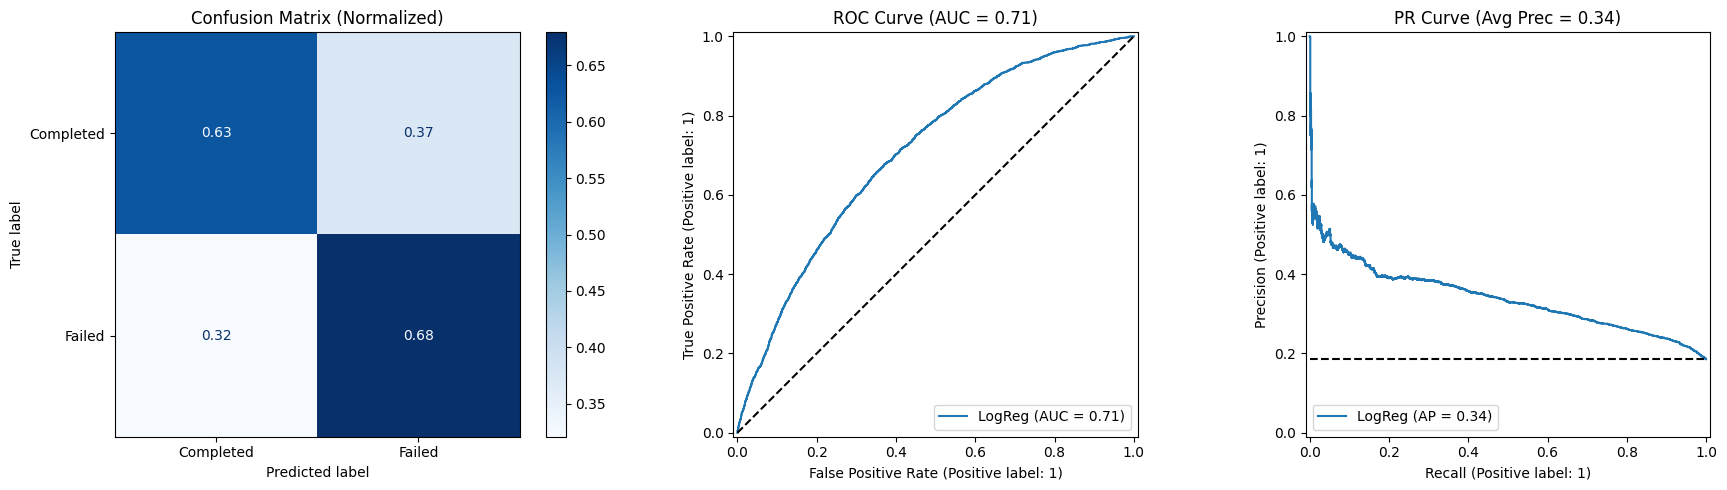

In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    classification_report,
    ConfusionMatrixDisplay,
    RocCurveDisplay,
    PrecisionRecallDisplay
)

# 1. Get Predictions
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# 2. Calculate Advanced Metrics
roc_score = roc_auc_score(y_test, y_prob)
pr_score = average_precision_score(y_test, y_prob)

print(f"--- MODEL PERFORMANCE METRICS ---")
print(f"ROC-AUC Score:      {roc_score:.4f}  (0.5 = Random, 1.0 = Perfect)")
print(f"PR-AUC Score:       {pr_score:.4f}   (Baseline: {y_test.mean():.4f})")
print("-" * 40)
print("CLASSIFICATION REPORT:")
print(classification_report(y_test, y_pred))

# 3. Visualizations
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

# A. Confusion Matrix (Normalized)
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred,
    normalize='true',
    cmap='Blues',
    display_labels=['Completed', 'Failed'],
    ax=ax[0]
)
ax[0].set_title("Confusion Matrix (Normalized)")

# B. ROC Curve
RocCurveDisplay.from_predictions(y_test, y_prob, ax=ax[1], name='LogReg')
ax[1].set_title(f"ROC Curve (AUC = {roc_score:.2f})")
ax[1].plot([0, 1], [0, 1], "k--", label="Chance")

# C. Precision-Recall Curve
PrecisionRecallDisplay.from_predictions(y_test, y_prob, ax=ax[2], name='LogReg')
ax[2].set_title(f"PR Curve (Avg Prec = {pr_score:.2f})")
ax[2].plot([0, 1], [y_test.mean(), y_test.mean()], "k--", label="Baseline")

plt.tight_layout()
plt.show()

# 3. Business Rule (Custom Threshold)
# We lower the threshold to catch more failures (High Recall strategy)

#threshold = 0.4
#y_pred_custom = (y_prob >= threshold).astype(int)
#tn, fp, fn, tp = confusion_matrix(y_test, y_pred_custom).ravel()

#recall = tp / (tp + fn)
#precision = tp / (tp + fp)


# 3. Visualizations
#fig, ax = plt.subplots(1, 3, figsize=(18, 5))

# A. Confusion Matrix (Normalized)
#ConfusionMatrixDisplay.from_predictions(
#    y_test, y_pred,
#    normalize='true',
#    cmap='Blues',
#    display_labels=['Completed', 'Failed'],
#    ax=ax[0]
#)
#ax[0].set_title("Confusion Matrix (Normalized)")

# B. ROC Curve
#RocCurveDisplay.from_predictions(y_test, y_prob, ax=ax[1], name='LogReg')
#ax[1].set_title(f"ROC Curve (AUC = {roc_score:.2f})")
#ax[1].plot([0, 1], [0, 1], "k--", label="Chance")

## C. Precision-Recall Curve
#PrecisionRecallDisplay.from_predictions(y_test, y_prob, ax=ax[2], name='LogReg')
#ax[2].set_title(f"PR Curve (Avg Prec = {pr_score:.2f})")
#ax[2].plot([0, 1], [y_test.mean(), y_test.mean()], "k--", label="Baseline")

#plt.tight_layout()
#plt.show()

--- 1. GENERALIZATION GAP (2000-2013 vs 2013-2015) ---
Train AUC (Past):   0.8434
Test AUC (Future):  0.7079
Gap:                0.1355
Verdict:   ⚠️ HIGH OVERFITTING (Memorizing the past, failing the future)

--- 2. GENERATING TEMPORAL LEARNING CURVE ---
(Using 5-Split Expanding Window: Train on Year 0-N, Validate on Year N+1)


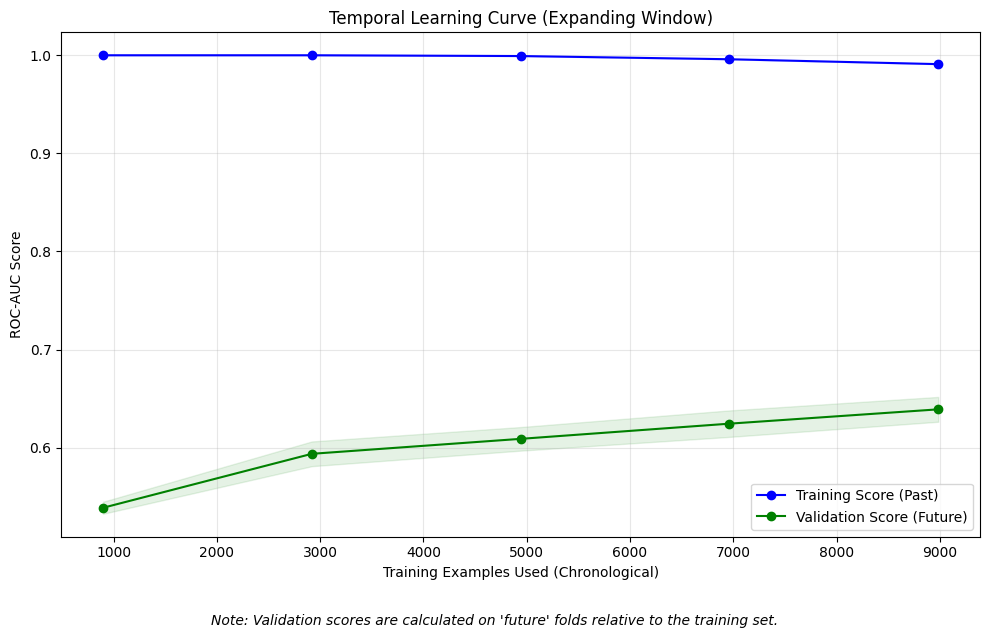

In [18]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import learning_curve, TimeSeriesSplit
from sklearn.metrics import roc_auc_score

def check_logreg_overfitting_temporal(model, X_train, y_train, X_test, y_test):
    """
    1. Calculates the Generalization Gap (Train vs Future Test).
    2. Generates a Time-Aware Learning Curve using TimeSeriesSplit.
       This prevents 'looking ahead' into the future during validation.
    """

    # --- PART 1: THE NUMBERS (Train vs Future Test) ---
    print("--- 1. GENERALIZATION GAP (2000-2013 vs 2013-2015) ---")

    y_train_prob = model.predict_proba(X_train)[:, 1]
    y_test_prob = model.predict_proba(X_test)[:, 1]

    train_auc = roc_auc_score(y_train, y_train_prob)
    test_auc = roc_auc_score(y_test, y_test_prob)
    gap = train_auc - test_auc

    print(f"Train AUC (Past):   {train_auc:.4f}")
    print(f"Test AUC (Future):  {test_auc:.4f}")
    print(f"Gap:                {gap:.4f}")

    if gap > 0.10:
        print("Verdict:   ⚠️ HIGH OVERFITTING (Memorizing the past, failing the future)")
    elif gap > 0.05:
        print("Verdict:   ⚠️ MODERATE OVERFITTING")
    else:
        print("Verdict:   ✅ GOOD TEMPORAL GENERALIZATION")

    # --- PART 2: THE VISUAL (Time-Series Learning Curve) ---
    print("\n--- 2. GENERATING TEMPORAL LEARNING CURVE ---")
    print("(Using 5-Split Expanding Window: Train on Year 0-N, Validate on Year N+1)")

    # CRITICAL CHANGE: Use TimeSeriesSplit instead of standard CV
    # This ensures we never train on future data to predict the past
    tscv = TimeSeriesSplit(n_splits=5)

    train_sizes, train_scores, val_scores = learning_curve(
        model,
        X_train,
        y_train,
        cv=tscv,           # <--- The Fix: Enforce Time Order
        scoring='roc_auc',
        n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 5),
        shuffle=False      # <--- The Fix: Do not shuffle rows
    )

    # Calculate means and standard deviations
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)

    # Plot
    plt.figure(figsize=(10, 6))

    # Plot Training Line
    plt.plot(train_sizes, train_mean, 'o-', color="blue", label="Training Score (Past)")
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="blue")

    # Plot Validation Line
    plt.plot(train_sizes, val_mean, 'o-', color="green", label="Validation Score (Future)")
    plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color="green")

    plt.title("Temporal Learning Curve (Expanding Window)")
    plt.xlabel("Training Examples Used (Chronological)")
    plt.ylabel("ROC-AUC Score")
    plt.legend(loc="best")
    plt.grid(True, alpha=0.3)

    # Add annotation explaining the split
    plt.figtext(0.5, -0.05, "Note: Validation scores are calculated on 'future' folds relative to the training set.",
                ha="center", fontsize=10, style='italic')

    plt.tight_layout()
    plt.show()

# --- EXECUTE ---
# Note: X_train must be sorted by date for this to work correctly.
# Your notebook sorted df by 'start_year' before splitting, so X_train is already sorted.
check_logreg_overfitting_temporal(model, X_train, y_train, X_test, y_test)

Running Deep Dive Analysis on Baseline Model...


/tmp/ipykernel_23114/325021978.py:119: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=slice_df, x='AUC', y='Slice', palette='viridis', ax=ax4)


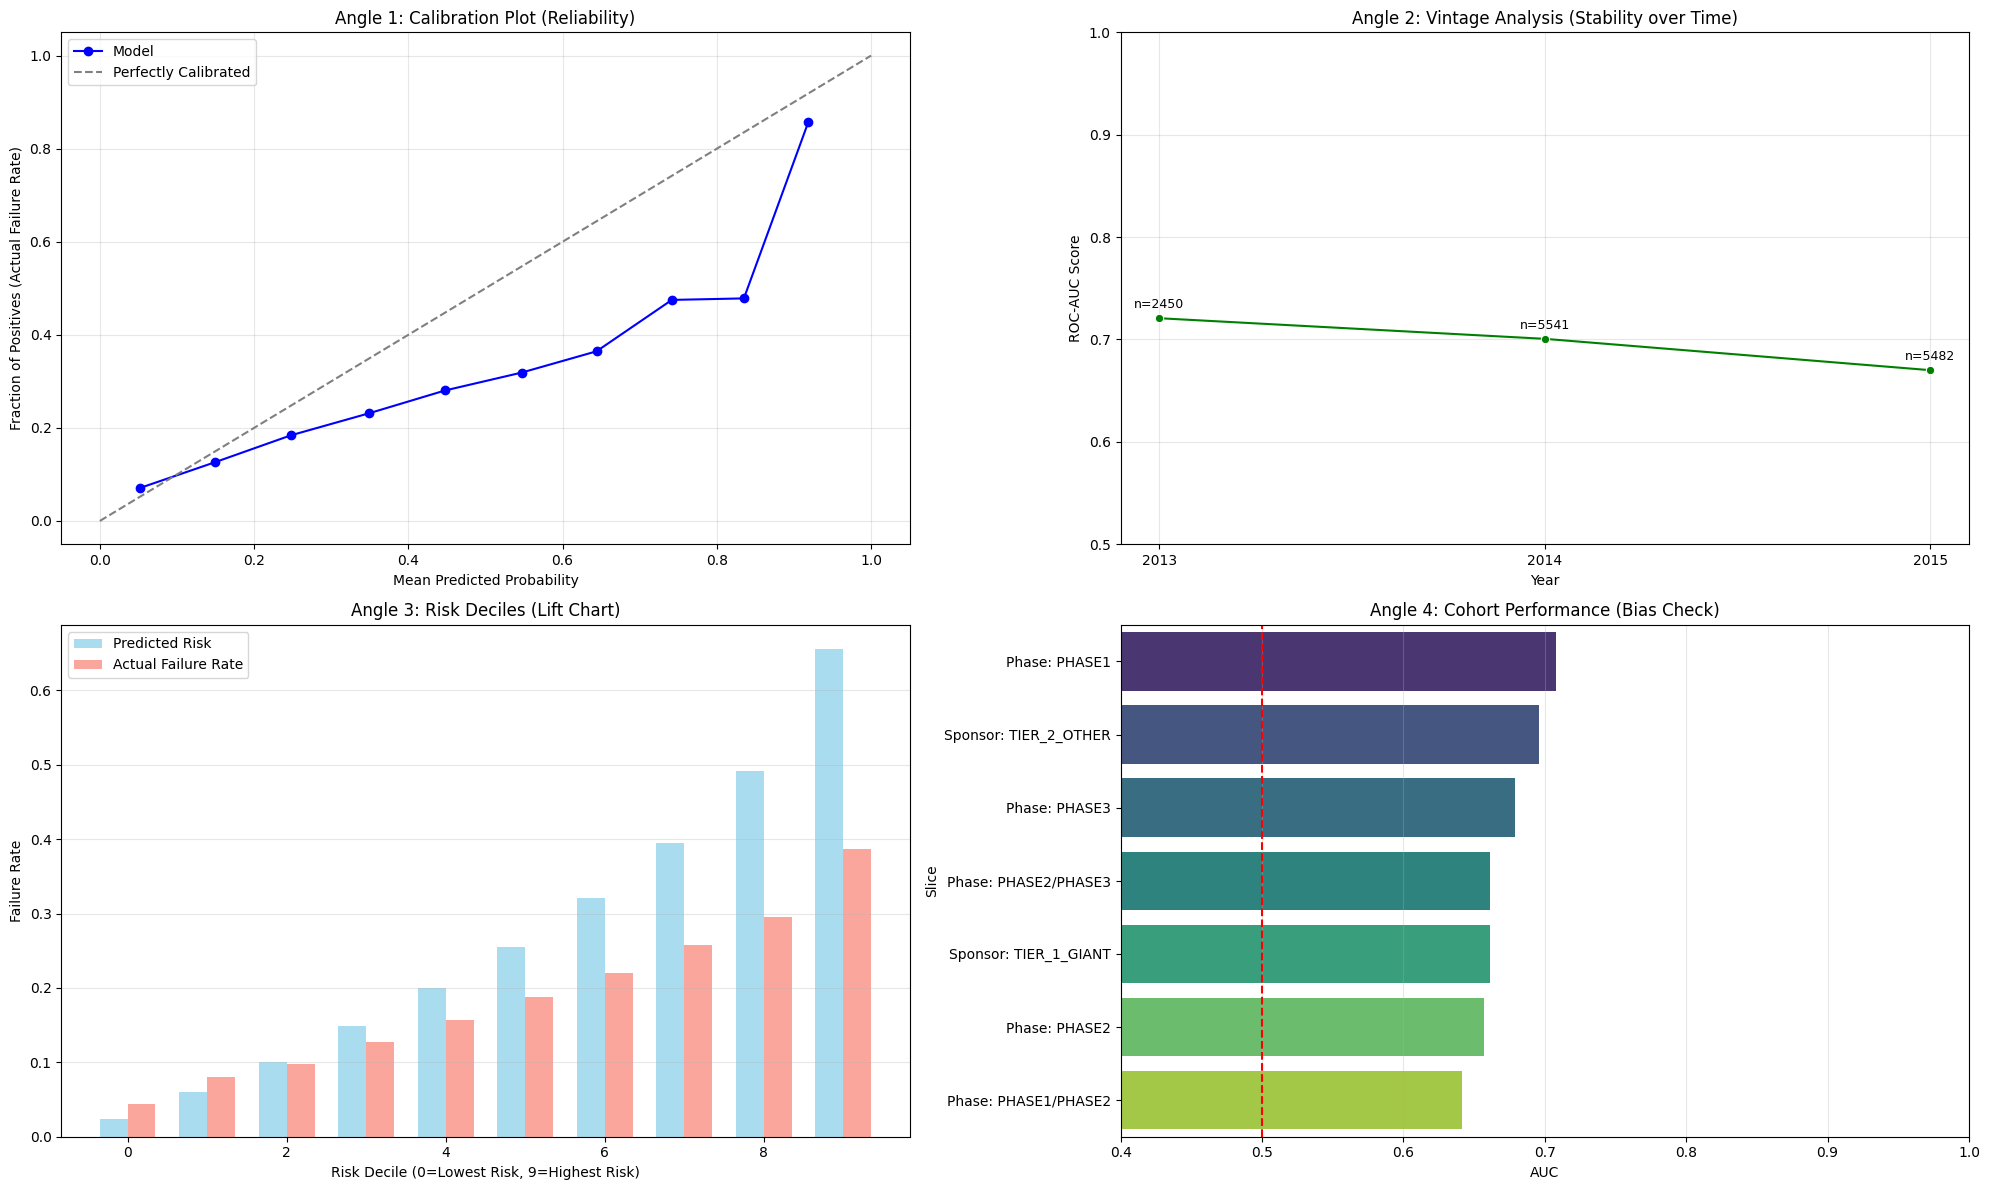

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.calibration import calibration_curve
from sklearn.metrics import roc_auc_score, precision_score, recall_score

def run_pro_analysis(model, X_test, y_test, raw_test_df):
    """
    Runs a 4-angle deep dive on model predictions.
    Requires:
    - model: Trained pipeline/model
    - X_test: Processed features (or raw if pipeline handles it)
    - y_test: Target labels
    - raw_test_df: The original dataframe for the test set (to extract Year/Phase/etc.)
    """

    # 1. Get Probabilities
    # Note: We take the probability of Class 1 (Failure)
    y_probs = model.predict_proba(X_test)[:, 1]

    # Create a temporary analysis dataframe
    analysis_df = raw_test_df.copy().reset_index(drop=True)
    analysis_df['target'] = y_test.values
    analysis_df['prob_failure'] = y_probs

    # Setup Plotting Grid
    fig, axes = plt.subplots(2, 2, figsize=(20, 12))
    plt.subplots_adjust(hspace=0.3)

    # ==============================================================================
    # ANGLE 1: CALIBRATION CURVE (Reliability)
    # ==============================================================================
    prob_true, prob_pred = calibration_curve(y_test, y_probs, n_bins=10)
    ax1 = axes[0, 0]
    ax1.plot(prob_pred, prob_true, marker='o', label='Model', color='blue')
    ax1.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
    ax1.set_xlabel('Mean Predicted Probability')
    ax1.set_ylabel('Fraction of Positives (Actual Failure Rate)')
    ax1.set_title('Angle 1: Calibration Plot (Reliability)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # ==============================================================================
    # ANGLE 2: VINTAGE ANALYSIS (Temporal Stability)
    # ==============================================================================
    # Group by Start Year and calculate AUC per year
    vintage_stats = []
    years = sorted(analysis_df['start_year'].unique())

    for year in years:
        subset = analysis_df[analysis_df['start_year'] == year]
        if len(subset) > 0 and subset['target'].nunique() > 1:
            auc = roc_auc_score(subset['target'], subset['prob_failure'])
            count = len(subset)
            vintage_stats.append({'Year': int(year), 'AUC': auc, 'Count': count})

    vintage_df = pd.DataFrame(vintage_stats)

    ax2 = axes[0, 1]
    sns.lineplot(data=vintage_df, x='Year', y='AUC', marker='o', color='green', ax=ax2)
    ax2.set_ylim(0.5, 1.0)
    ax2.set_title('Angle 2: Vintage Analysis (Stability over Time)')
    ax2.set_ylabel('ROC-AUC Score')
    ax2.set_xticks(vintage_df['Year'])
    ax2.grid(True, alpha=0.3)

    # Add count labels
    for index, row in vintage_df.iterrows():
        ax2.text(row['Year'], row['AUC'] + 0.01, f"n={int(row['Count'])}", ha='center', fontsize=9)

    # ==============================================================================
    # ANGLE 3: RISK DECILE ANALYSIS (Business Impact)
    # ==============================================================================
    # Bin predictions into 10 buckets (Deciles)
    analysis_df['decile'] = pd.qcut(analysis_df['prob_failure'], 10, labels=False, duplicates='drop')

    decile_stats = analysis_df.groupby('decile').agg({
        'target': 'mean',          # Actual Failure Rate
        'prob_failure': 'mean'     # Predicted Failure Rate
    }).reset_index()

    ax3 = axes[1, 0]
    width = 0.35
    x = np.arange(len(decile_stats))

    ax3.bar(x - width/2, decile_stats['prob_failure'], width, label='Predicted Risk', color='skyblue', alpha=0.7)
    ax3.bar(x + width/2, decile_stats['target'], width, label='Actual Failure Rate', color='salmon', alpha=0.7)

    ax3.set_xlabel('Risk Decile (0=Lowest Risk, 9=Highest Risk)')
    ax3.set_ylabel('Failure Rate')
    ax3.set_title('Angle 3: Risk Deciles (Lift Chart)')
    ax3.legend()
    ax3.grid(axis='y', alpha=0.3)

    # ==============================================================================
    # ANGLE 4: COHORT SLICING (Phase & Sponsor)
    # ==============================================================================
    # Calculate AUC for specific slices
    slices = []

    # Slice by Phase
    for phase in analysis_df['phase'].unique():
        subset = analysis_df[analysis_df['phase'] == phase]
        if len(subset) > 50 and subset['target'].nunique() > 1:
            auc = roc_auc_score(subset['target'], subset['prob_failure'])
            slices.append({'Slice': f"Phase: {phase}", 'AUC': auc})

    # Slice by Sponsor Tier
    for tier in analysis_df['sponsor_tier'].unique():
        subset = analysis_df[analysis_df['sponsor_tier'] == tier]
        if len(subset) > 50 and subset['target'].nunique() > 1:
            auc = roc_auc_score(subset['target'], subset['prob_failure'])
            slices.append({'Slice': f"Sponsor: {tier}", 'AUC': auc})

    slice_df = pd.DataFrame(slices).sort_values('AUC', ascending=False)

    ax4 = axes[1, 1]
    sns.barplot(data=slice_df, x='AUC', y='Slice', palette='viridis', ax=ax4)
    ax4.set_xlim(0.4, 1.0)
    ax4.set_title('Angle 4: Cohort Performance (Bias Check)')
    ax4.axvline(0.5, color='red', linestyle='--', label='Random')
    ax4.grid(axis='x', alpha=0.3)

    plt.tight_layout()
    plt.show()

    return analysis_df

# ---------------------------------------------------------
# EXECUTE ANALYSIS
# ---------------------------------------------------------
# Ensure we pass the raw test dataframe to get columns like 'start_year' and 'phase' back
# We use test_df (which you defined in cell 11 of your notebook)
print("Running Deep Dive Analysis on Baseline Model...")
results_df = run_pro_analysis(model, X_test, y_test, test_df)

In [13]:
import pandas as pd
import numpy as np

# 1. Load Data (Assuming 'df' is your loaded dataframe from the loader)
# If df is not in memory, uncomment:
# from src.data_loader_tx import ClinicalTrialLoader
# loader = ClinicalTrialLoader(data_path='data/')
# df = loader.load_and_clean()
# df = loader.add_features(df)

print("=== 1. PHASE MAPPING AUDIT ===")
# Check how raw phases map to the ordinal feature
phase_check = df[['phase', 'phase_ordinal']].drop_duplicates().sort_values('phase_ordinal')
print(phase_check)

print("\n=== 2. FEATURE DISTRIBUTION AUDIT (Pre-Scaling) ===")
# Check stats of numerical columns to see their natural range
num_cols = ['competition_broad', 'num_primary_endpoints', 'criteria_len_log', 'start_year']
print(df[num_cols].describe().loc[['min', 'max', 'mean', 'std']])

print("\n=== 3. MISSING VALUES CHECK ===")
# XGBoost handles NaNs automatically, but good to know
missing = df.isnull().sum()
print(missing[missing > 0])

=== 1. PHASE MAPPING AUDIT ===
            phase  phase_ordinal
4          PHASE1              1
0          PHASE2              2
3   PHASE1/PHASE2              2
7          PHASE3              3
25  PHASE2/PHASE3              3

=== 2. FEATURE DISTRIBUTION AUDIT (Pre-Scaling) ===
      competition_broad  num_primary_endpoints  criteria_len_log   start_year
min            1.000000               1.000000          1.386294  2000.000000
max         3215.000000             118.000000          9.805709  2015.000000
mean        1387.253834               1.786248          7.316935  2008.995606
std         1071.951975               2.677579          0.924245     4.009484

=== 3. MISSING VALUES CHECK ===
start_date_type       52559
number_of_arms         8683
why_stopped           58783
allocation            16563
intervention_model     1881
primary_purpose        1919
masking                1292
txt_criteria             19
dtype: int64


In [14]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.model_selection import TimeSeriesSplit

# ==============================================================================
# 0. SETUP & DATA PREP
# ==============================================================================
print(">>> STARTING XGBOOST AUDIT <<<\n")

# Ensure we have the data loaded (from previous cells)
# We assume X_train, y_train, X_test, y_test are available from your split
# We explicitly drop leakage columns again just to be safe for the audit
audit_drop_cols = ['target', 'overall_status', 'nct_id', 'why_stopped', 'start_date_type']
X_audit = train_df.drop(columns=audit_drop_cols, errors='ignore')
y_audit = train_df['target']

# Fit the preprocessor ONCE to get feature names and transformed data
print("1. Preprocessing Data...")
preprocessor = get_pipeline()
X_audit_trans = preprocessor.fit_transform(X_audit, y_audit)

# Get feature names
try:
    feat_names = preprocessor.get_feature_names_out()
except:
    # Fallback if sklearn version is old
    feat_names = [f"feat_{i}" for i in range(X_audit_trans.shape[1])]

print(f"   Feature Count: {len(feat_names)}")
print(f"   Row Count: {X_audit_trans.shape[0]}")

# ==============================================================================
# 1. CLASS IMBALANCE & WEIGHTING
# ==============================================================================
print("\n=== AUDIT 1: CLASS BALANCE ===")
neg, pos = np.bincount(y_audit)
ratio = neg / pos
print(f"   Negative (Completed): {neg}")
print(f"   Positive (Failed):    {pos}")
print(f"   Imbalance Ratio:      {ratio:.4f}")
print(f"   -> Recommended scale_pos_weight: {ratio:.2f}")

# ==============================================================================
# 2. BASELINE XGBOOST SIGNAL CHECK
# ==============================================================================
print("\n=== AUDIT 2: RAW SIGNAL CHECK (Default XGB) ===")
# Train a quick default model to see what features it picks naturally
model_default = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    scale_pos_weight=ratio,
    random_state=42,
    n_jobs=-1
)
model_default.fit(X_audit_trans, y_audit)

# Get Feature Importances
importances = model_default.feature_importances_
indices = np.argsort(importances)[::-1]

print("   Top 15 Most Important Features (Gain):")
for f in range(15):
    print(f"   {f+1}. {feat_names[indices[f]]}: {importances[indices[f]]:.4f}")

# Check for "Dead" features
zero_imp = np.sum(importances == 0)
print(f"   \n   Features with 0 importance: {zero_imp} / {len(feat_names)}")

# ==============================================================================
# 3. DEPTH SENSITIVITY PROBE (Complexity Check)
# ==============================================================================
print("\n=== AUDIT 3: DEPTH SENSITIVITY (Overfitting Check) ===")
# We check depths 3, 6, and 10 to see if the model needs complex interactions
# Using TimeSeriesSplit to simulate the Train/Test split logic
tscv = TimeSeriesSplit(n_splits=3)

for depth in [3, 6, 10]:
    fold_aucs_train = []
    fold_aucs_val = []

    for train_ix, val_ix in tscv.split(X_audit_trans):
        X_t, X_v = X_audit_trans[train_ix], X_audit_trans[val_ix]
        y_t, y_v = y_audit.iloc[train_ix], y_audit.iloc[val_ix]

        m = xgb.XGBClassifier(max_depth=depth, n_estimators=50, scale_pos_weight=ratio, random_state=42, n_jobs=-1)
        m.fit(X_t, y_t)

        fold_aucs_train.append(roc_auc_score(y_t, m.predict_proba(X_t)[:,1]))
        fold_aucs_val.append(roc_auc_score(y_v, m.predict_proba(X_v)[:,1]))

    avg_train = np.mean(fold_aucs_train)
    avg_val = np.mean(fold_aucs_val)
    gap = avg_train - avg_val

    print(f"   Depth {depth}: Train AUC={avg_train:.3f} | Val AUC={avg_val:.3f} | Gap={gap:.3f}")

# ==============================================================================
# 4. CORRELATION & REDUNDANCY CHECK
# ==============================================================================
print("\n=== AUDIT 4: HIGH CORRELATION CHECK ===")
# Convert to DF for correlation (using a sample to save memory if needed)
df_trans = pd.DataFrame(X_audit_trans, columns=feat_names)
# Calculate correlation matrix
corr_matrix = df_trans.corr().abs()
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

print(f"   Number of features with correlation > 0.95: {len(to_drop)}")
if len(to_drop) > 0:
    print(f"   Examples: {to_drop[:5]}")
else:
    print("   No highly redundant features found.")

# ==============================================================================
# 5. TARGET DISTRIBUTION OVER TIME
# ==============================================================================
print("\n=== AUDIT 5: TARGET STABILITY OVER TIME ===")
# We need the original 'start_year' from the dataframe before transformation
yearly_fail_rate = train_df.groupby('start_year')['target'].mean()
print("   Failure Rate by Year (Check for drastic changes):")
print(yearly_fail_rate.tail(10)) # Print last 10 years of training data

print("\n>>> AUDIT COMPLETE <<<")

>>> STARTING XGBOOST AUDIT <<<

1. Preprocessing Data...
   Feature Count: 232
   Row Count: 53890

=== AUDIT 1: CLASS BALANCE ===
   Negative (Completed): 45441
   Positive (Failed):    8449
   Imbalance Ratio:      5.3783
   -> Recommended scale_pos_weight: 5.38

=== AUDIT 2: RAW SIGNAL CHECK (Default XGB) ===
   Top 15 Most Important Features (Gain):
   1. healthy_volunteers_f: 0.0911
   2. healthy_volunteers_t: 0.0409
   3. sponsor_clean: 0.0282
   4. therapeutic_area_Psychiatry: 0.0162
   5. intervention_model_UNKNOWN: 0.0161
   6. start_year: 0.0129
   7. includes_us_1: 0.0125
   8. intervention_model_CROSSOVER: 0.0112
   9. best_pathology: 0.0080
   10. primary_purpose_TREATMENT: 0.0074
   11. emb_3: 0.0073
   12. phase_ordinal: 0.0071
   13. agency_class_NIH: 0.0070
   14. therapeutic_subgroup_name: 0.0070
   15. adult_t: 0.0069
   
   Features with 0 importance: 30 / 232

=== AUDIT 3: DEPTH SENSITIVITY (Overfitting Check) ===
   Depth 3: Train AUC=0.823 | Val AUC=0.690 | Gap=0

In [15]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import TimeSeriesSplit

# ==============================================================================
# 0. SETUP & DATA PREP
# ==============================================================================
print(">>> STARTING LEAK HUNTER AUDIT <<<\n")

# 1. Define Drop List (Standard + Suspects)
# We purposely keep 'enrollment' for a moment to check if it's the leak
base_drop_cols = ['target', 'overall_status', 'nct_id', 'why_stopped', 'start_date_type']

# Ensure Data is ready
X_audit = train_df.drop(columns=base_drop_cols, errors='ignore')
y_audit = train_df['target']

# 2. Preprocess
print("1. Preprocessing Data...")
preprocessor = get_pipeline()
X_audit_trans = preprocessor.fit_transform(X_audit, y_audit)

# Get feature names
try:
    feat_names = preprocessor.get_feature_names_out()
except:
    feat_names = [f"feat_{i}" for i in range(X_audit_trans.shape[1])]

print(f"   Feature Count: {len(feat_names)}")

# ==============================================================================
# AUDIT 1: THE "CHEAT CODE" DETECTOR (Feature Importance)
# ==============================================================================
print("\n=== AUDIT 1: IDENTIFYING THE LEAK (Feature Importance) ===")
# Train a deep tree to let it exploit any leaks
model_leak = xgb.XGBClassifier(
    n_estimators=50,
    max_depth=6,
    random_state=42,
    n_jobs=-1
)
model_leak.fit(X_audit_trans, y_audit)

# Extract Importances
importances = model_leak.feature_importances_
indices = np.argsort(importances)[::-1]

print("   TOP 20 FEATURES (If #1 is > 0.20, it is likely a leak):")
print("   -------------------------------------------------------")
for f in range(20):
    name = feat_names[indices[f]]
    score = importances[indices[f]]
    print(f"   {f+1}. {name:<40} : {score:.4f}")

# ==============================================================================
# AUDIT 2: CORRELATION WITH TARGET
# ==============================================================================
print("\n=== AUDIT 2: DIRECT CORRELATION WITH TARGET ===")
# We check if any single feature is perfectly correlated with the target
# (Convert sparse to dense for correlation check if necessary, usually safe for 50k rows)
try:
    if hasattr(X_audit_trans, "toarray"):
        X_dense = X_audit_trans.toarray()
    else:
        X_dense = X_audit_trans

    # Calculate correlation of every feature with y_audit
    correlations = []
    for i in range(X_dense.shape[1]):
        corr = np.corrcoef(X_dense[:, i], y_audit)[0, 1]
        correlations.append((feat_names[i], corr))

    # Sort by absolute correlation
    correlations.sort(key=lambda x: abs(x[1]), reverse=True)

    print("   TOP 10 FEATURES CORRELATED WITH TARGET:")
    for name, corr in correlations[:10]:
        print(f"   {name:<40} : {corr:.4f}")

except Exception as e:
    print(f"   (Skipped Correlation check due to memory/format: {e})")

# ==============================================================================
# AUDIT 3: OVERFITTING STRESS TEST (Regularization Check)
# ==============================================================================
print("\n=== AUDIT 3: CAN WE BREAK THE OVERFITTING? ===")
# We try a very constrained model. If Train AUC stays ~0.99, the data is broken (leakage).
# If Train AUC drops to ~0.75, the data is fine, and we just need to tune parameters.

print("   Training Constrained Model (Depth=3, Eta=0.05)...")
model_constrained = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=3,           # Shallow trees
    learning_rate=0.05,    # Slow learning
    colsample_bytree=0.5,  # Force diversity
    random_state=42,
    n_jobs=-1
)
model_constrained.fit(X_audit_trans, y_audit)

train_pred = model_constrained.predict_proba(X_audit_trans)[:, 1]
train_auc = roc_auc_score(y_audit, train_pred)

print(f"   Constrained Train AUC: {train_auc:.4f}")

if train_auc > 0.90:
    print("   >>> CRITICAL: Even a weak model gets >0.90 AUC.")
    print("   >>> CONCLUSION: You definitely have a Data Leak.")
else:
    print("   >>> GOOD NEWS: The weak model struggles (AUC < 0.90).")
    print("   >>> CONCLUSION: The previous overfitting was due to parameters, not leakage.")

print("\n>>> AUDIT COMPLETE <<<")

>>> STARTING LEAK HUNTER AUDIT <<<

1. Preprocessing Data...
   Feature Count: 232

=== AUDIT 1: IDENTIFYING THE LEAK (Feature Importance) ===
   TOP 20 FEATURES (If #1 is > 0.20, it is likely a leak):
   -------------------------------------------------------
   1. healthy_volunteers_f                     : 0.0715
   2. healthy_volunteers_t                     : 0.0402
   3. sponsor_clean                            : 0.0395
   4. competition_broad                        : 0.0138
   5. includes_us_1                            : 0.0117
   6. start_year                               : 0.0116
   7. agency_class_NIH                         : 0.0098
   8. therapeutic_subgroup_name                : 0.0095
   9. best_pathology                           : 0.0092
   10. number_of_arms                           : 0.0092
   11. phase_ordinal                            : 0.0086
   12. intervention_model_CROSSOVER             : 0.0075
   13. agency_class_INDUSTRY                    : 0.0071
   14. 

/home/delaunan/.pyenv/versions/clintrialpredict/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/delaunan/.pyenv/versions/clintrialpredict/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


   TOP 10 FEATURES CORRELATED WITH TARGET:
   covid_exposure_0                         : nan
   sponsor_clean                            : 0.2230
   best_pathology                           : 0.1469
   therapeutic_subgroup_name                : 0.1456
   healthy_volunteers_f                     : 0.1291
   healthy_volunteers_t                     : -0.1282
   emb_3                                    : 0.1230
   agency_class_OTHER                       : 0.1167
   therapeutic_area_Oncology                : 0.1159
   agency_class_INDUSTRY                    : -0.1138

=== AUDIT 3: CAN WE BREAK THE OVERFITTING? ===
   Training Constrained Model (Depth=3, Eta=0.05)...
   Constrained Train AUC: 0.7295
   >>> GOOD NEWS: The weak model struggles (AUC < 0.90).
   >>> CONCLUSION: The previous overfitting was due to parameters, not leakage.

>>> AUDIT COMPLETE <<<


In [19]:
import pandas as pd
import numpy as np
from src.preprocessing_tx import get_pipeline

# 1. PREPARE RAW DATA (Drop Leakage & Target)
# ---------------------------------------------------------
# We assume 'train_df' is already loaded from your previous cells
drop_cols_final = ['target', 'overall_status', 'nct_id', 'why_stopped', 'start_date_type']

X_train_raw = train_df.drop(columns=drop_cols_final, errors='ignore')
y_train_final = train_df['target']

# 2. TRANSFORM DATA (Convert Text/Cats to Numbers)
# ---------------------------------------------------------
print(">>> Transforming training data (OneHot, TargetEncoding, Embeddings)...")

# Initialize the pipeline from your src file
preprocessor = get_pipeline()

# Fit and Transform
# CRITICAL: We pass y_train_final because TargetEncoder needs labels to learn
X_train_transformed = preprocessor.fit_transform(X_train_raw, y_train_final)

# 3. RECOVER FEATURE NAMES
# ---------------------------------------------------------
# We need names so RFECV tells us "sponsor_tier" is important, not "feature_42"
try:
    feature_names = preprocessor.get_feature_names_out()
except:
    # Fallback if sklearn version is old, but get_feature_names_out is standard now
    feature_names = [f"feat_{i}" for i in range(X_train_transformed.shape[1])]

# 4. CREATE X_TRAIN_FINAL DATAFRAME
# ---------------------------------------------------------
# If the output is a sparse matrix (common with text), convert to dense for DataFrame
if hasattr(X_train_transformed, "toarray"):
    X_train_transformed = X_train_transformed.toarray()

X_train_final = pd.DataFrame(
    X_train_transformed,
    columns=feature_names,
    index=X_train_raw.index # Keep original indices
)

print("\n✅ DATA READY FOR RFECV")
print(f"Shape: {X_train_final.shape}")
print(f"Features: {list(X_train_final.columns[:5])} ...") # Preview first 5 features

>>> Transforming training data (OneHot, TargetEncoding, Embeddings)...

✅ DATA READY FOR RFECV
Shape: (53890, 232)
Features: ['competition_niche', 'competition_broad', 'num_primary_endpoints', 'number_of_arms', 'criteria_len_log'] ...


RFECV

>>> Running Recursive Feature Elimination (this takes time)...
Optimal number of features: 77
Best PR-AUC Score: 0.3183

>>> THE SURVIVORS (Use these in your UI):
['competition_niche', 'competition_broad', 'num_primary_endpoints', 'number_of_arms', 'criteria_len_log', 'start_year', 'phase_ordinal', 'is_international_1', 'healthy_volunteers_f', 'healthy_volunteers_t', 'includes_us_1', 'agency_class_INDUSTRY', 'masking_NONE', 'masking_TRIPLE', 'masking_UNKNOWN', 'intervention_model_CROSSOVER', 'intervention_model_UNKNOWN', 'allocation_UNKNOWN', 'therapeutic_area_Psychiatry', 'sponsor_tier_TIER_1_GIANT', 'therapeutic_subgroup_name', 'best_pathology', 'sponsor_clean', 'truncatedsvd1', 'truncatedsvd2', 'truncatedsvd5', 'truncatedsvd7', 'truncatedsvd8', 'truncatedsvd10', 'truncatedsvd11', 'truncatedsvd18', 'truncatedsvd19', 'truncatedsvd20', 'truncatedsvd21', 'truncatedsvd23', 'truncatedsvd24', 'truncatedsvd25', 'truncatedsvd28', 'truncatedsvd31', 'truncatedsvd32', 'truncatedsvd35', 'truncat

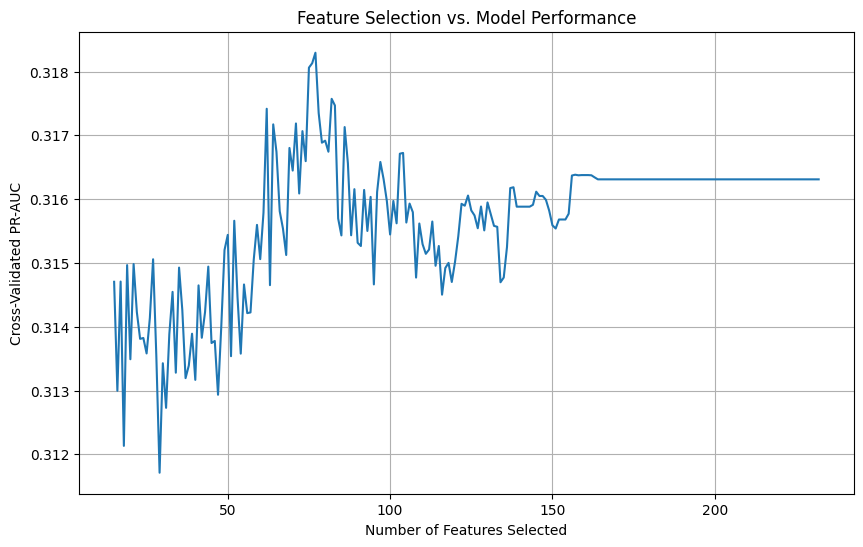

In [20]:
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFECV
from sklearn.model_selection import TimeSeriesSplit
from xgboost import XGBClassifier

# 1. Setup Data (Use your existing X_train_final from previous steps)
# Ensure it's numeric (if using pipeline, transform it first)
# If X_train_final is a DataFrame from the pipeline:
X_for_selection = X_train_final
y_for_selection = y_train_final

# 2. Define the Estimator
# Use a faster version of your model for selection (fewer trees)
xgb_selector = XGBClassifier(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    scale_pos_weight=5.38, # Your calculated ratio
    n_jobs=-1,
    random_state=42,
    eval_metric='aucpr'
)

# 3. Run RFECV (The Automation)
# - step=1: Remove 1 feature at a time (most accurate)
# - min_features_to_select=10: Don't go below 10
# - cv=TimeSeriesSplit: Respect the timeline!
print(">>> Running Recursive Feature Elimination (this takes time)...")

rfecv = RFECV(
    estimator=xgb_selector,
    step=1,
    cv=TimeSeriesSplit(n_splits=3),
    scoring='average_precision', # Optimize for PR-AUC
    min_features_to_select=15,
    n_jobs=-1
)

rfecv.fit(X_for_selection, y_for_selection)

# 4. Results
print(f"Optimal number of features: {rfecv.n_features_}")
print(f"Best PR-AUC Score: {max(rfecv.cv_results_['mean_test_score']):.4f}")

# 5. Get the Survivors
selected_features = X_for_selection.columns[rfecv.support_]
print("\n>>> THE SURVIVORS (Use these in your UI):")
print(list(selected_features))

# 6. Plot the "Optimization Curve"
plt.figure(figsize=(10, 6))
plt.xlabel("Number of Features Selected")
plt.ylabel("Cross-Validated PR-AUC")
plt.plot(
    range(15, len(rfecv.cv_results_['mean_test_score']) + 15),
    rfecv.cv_results_['mean_test_score']
)
plt.title("Feature Selection vs. Model Performance")
plt.grid(True)
plt.show()

xgb_final

In [21]:
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline

# 1. DATA SETUP (Standard Safety)
drop_cols_final = ['target', 'overall_status', 'nct_id', 'why_stopped', 'start_date_type']

# Ensure we use the original split
X_train_final = train_df.drop(columns=drop_cols_final, errors='ignore')
y_train_final = train_df['target']
X_test_final = test_df.drop(columns=drop_cols_final, errors='ignore')
y_test_final = test_df['target']

# 2. DEFINE xgb_final
# This configuration is based on your successful Audit #3
xgb_final = Pipeline(steps=[
    ('preprocessor', get_pipeline()),
    ('classifier', XGBClassifier(
        # --- The "Anti-Overfitting" Architecture ---
        n_estimators=1500,       # High trees...
        learning_rate=0.02,      # ...Low speed (Crucial for generalization)
        max_depth=3,             # Depth 3: The setting that fixed your 0.99 overfitting

        # --- Robustness ---
        subsample=0.7,           # Train on 70% of rows
        colsample_bytree=0.5,    # Train on 50% of features (Forces embedding usage)
        min_child_weight=5,      # Reduces sensitivity to outliers
        gamma=1.0,               # Conservative tree pruning

        # --- Imbalance ---
        scale_pos_weight=5.38,   # Your calculated ratio

        # --- Tech Specs ---
        objective='binary:logistic',
        eval_metric='aucpr',
        random_state=42,
        n_jobs=-1
    ))
])

# 3. TRAIN
print(">>> Training xgb_final...")
xgb_final.fit(X_train_final, y_train_final)
print(">>> Ready for Permutation Importance.")

>>> Training xgb_final...
>>> Ready for Permutation Importance.


In [22]:
from sklearn.inspection import permutation_importance

# 1. Setup (Use your trained 'xgb_final' or 'xgb_lean' pipeline)
# We need to pass the *Test Set* to see what actually matters for future predictions
print(">>> Running Permutation Importance on TEST SET (Future Data)...")

# Note: We pass the full pipeline so it handles the raw X_test
result = permutation_importance(
    xgb_final,
    X_test,           # Raw Test Data (2013-2015)
    y_test,
    n_repeats=10,     # Shuffle 10 times for statistical stability
    random_state=42,
    n_jobs=-1,
    scoring='average_precision' # Focus on PR-AUC
)

# 2. Organize Results
perm_df = pd.DataFrame({
    'feature': X_test.columns, # This assumes X_test has columns. If numpy, use feature_names
    'importance_mean': result.importances_mean,
    'importance_std': result.importances_std
})

# 3. Sort by Impact
perm_df = perm_df.sort_values('importance_mean', ascending=False)

# 4. Display the "True" Drivers
print("\n=== TRUE PREDICTIVE DRIVERS (Test Set) ===")
print(perm_df.head(15))

# 5. Identify "Fake" Friends
# Features that the model learned but don't actually help on Test Data
useless_features = perm_df[perm_df['importance_mean'] <= 0]
print(f"\n>>> Features with <= 0 importance on Test Data: {len(useless_features)}")
print(list(useless_features['feature'].values))

>>> Running Permutation Importance on TEST SET (Future Data)...

=== TRUE PREDICTIVE DRIVERS (Test Set) ===
                       feature  importance_mean  importance_std
16               sponsor_clean         0.061709        0.005125
19          healthy_volunteers         0.009740        0.001014
7                  includes_us         0.009309        0.002667
5                phase_ordinal         0.004997        0.001177
34                       emb_3         0.004284        0.001323
24              best_pathology         0.004230        0.000768
29                    txt_tags         0.003929        0.001444
26   therapeutic_subgroup_name         0.003302        0.001215
8             is_international         0.002903        0.000834
3               number_of_arms         0.002619        0.001234
27           competition_broad         0.002117        0.000328
13       num_primary_endpoints         0.001662        0.000602
10          intervention_model         0.001586        0.000